## Checking paths to load data

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import gc

import warnings
warnings.filterwarnings("ignore")

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/amex-default-prediction/sample_submission.csv
/kaggle/input/amex-default-prediction/train_data.csv
/kaggle/input/amex-default-prediction/test_data.csv
/kaggle/input/amex-default-prediction/train_labels.csv
/kaggle/input/amexfeather/test_data_f32.ftr
/kaggle/input/amexfeather/train_data.ftr
/kaggle/input/amexfeather/train_data_f32.ftr
/kaggle/input/amexfeather/test_data.ftr


## Loading data - last record for each customer (to reduce the RAM usage)

In [4]:
train_dataset_ = pd.read_feather('../input/amexfeather/train_data.ftr')

# Keep the latest record features for each customer
train_dataset = train_dataset_.groupby('customer_ID').tail(1).set_index('customer_ID', drop=True).sort_index()

In [5]:
customerID_array = train_dataset.index
type(customerID_array)

pandas.core.indexes.base.Index

In [6]:
del train_dataset_ # to reduce ram usage
gc.collect()

46

## Dataset summary

In [7]:
train_dataset.describe()

,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_42,D_43,...,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,target
count,455944.000000,4.589130e+05,458913.000000,4.588820e+05,4.589130e+05,373943.000000,4.588820e+05,4.588820e+05,59910.000000,324591.000000,...,1.639500e+04,1.639500e+04,456083.000000,458913.000000,4.560830e+05,80315.000000,456083.000000,458913.000000,456083.000000,458913.000000
mean,NaN,NaN,0.000000,NaN,0.000000e+00,NaN,0.000000e+00,NaN,0.177979,0.000000,...,1.412201e-02,1.589355e-01,NaN,0.000000,NaN,0.000000,NaN,0.000000,0.000000,0.258934
std,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.253662,0.000000,...,9.527588e-02,2.609863e-01,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.438050
min,-0.458984,5.960464e-08,-3.570312,1.788139e-07,5.960464e-08,-0.508789,5.960464e-08,5.960464e-08,-0.000240,0.000002,...,3.576279e-07,1.788139e-07,0.000000,0.000000,1.192093e-07,-0.011436,0.000000,0.000000,0.000000,0.000000
25%,0.449219,4.783630e-03,0.008987,7.092285e-02,2.956390e-03,0.127563,3.007889e-03,5.485535e-03,0.031769,0.043335,...,2.519608e-03,3.482819e-03,0.003046,0.002552,3.026962e-03,0.200684,0.003033,0.002758,0.003031,0.000000
50%,0.682617,9.559631e-03,0.033234,8.134766e-01,5.920410e-03,0.164917,6.011963e-03,1.083374e-02,0.108276,0.092407,...,5.050659e-03,7.026672e-03,0.006077,0.005119,6.050110e-03,0.385986,0.006065,0.005501,0.006073,0.000000
75%,0.862305,2.666016e-01,0.153687,1.001953e+00,8.888245e-03,0.264893,8.995056e-03,2.106934e-01,0.230347,0.195068,...,7.579803e-03,5.014648e-01,0.009102,0.007675,9.101868e-03,0.573730,0.009094,0.008255,0.009102,1.000000
max,1.009766,5.000000e+00,1.324219,1.009766e+00,2.759766e+00,3.994141,8.992188e+00,1.596680e+00,4.187500,9.187500,...,1.009766e+00,2.505859e+00,1.009766,1.009766,1.339844e+00,2.228516,1.009766,1.343750,4.828125,1.000000


## Analyze categorical columns

In [8]:
categorical_cols = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']

num_cols = [col for col in train_dataset.columns if col not in categorical_cols + ["target"]]

print(f'Total number of features: {1}')
print(f'Total number of categorical features: {len(categorical_cols)}')
print(f'Total number of continuos features: {len(num_cols)}')

Total number of features: 1
Total number of categorical features: 11
Total number of continuos features: 178


<AxesSubplot:xlabel='target', ylabel='count'>

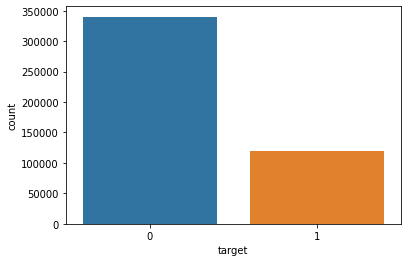

In [9]:
sns.countplot(x = 'target', data = train_dataset)

## Sampling dataset to balance

In [10]:
train_dataset["target"].value_counts()

0    340085
1    118828
Name: target, dtype: int64

In [11]:
remove_n = 200000
index = train_dataset["target"] == 0
drop_indices = np.random.choice(train_dataset[index].index, remove_n, replace=False)
train_dataset = train_dataset.drop(drop_indices)

<AxesSubplot:xlabel='target', ylabel='count'>

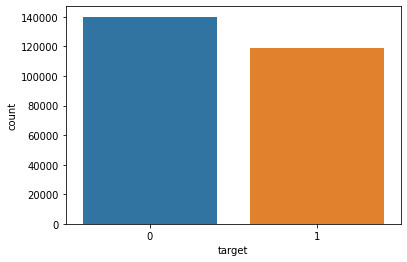

In [12]:
sns.countplot(x = 'target', data = train_dataset)

## Visualizing categorial features against the target

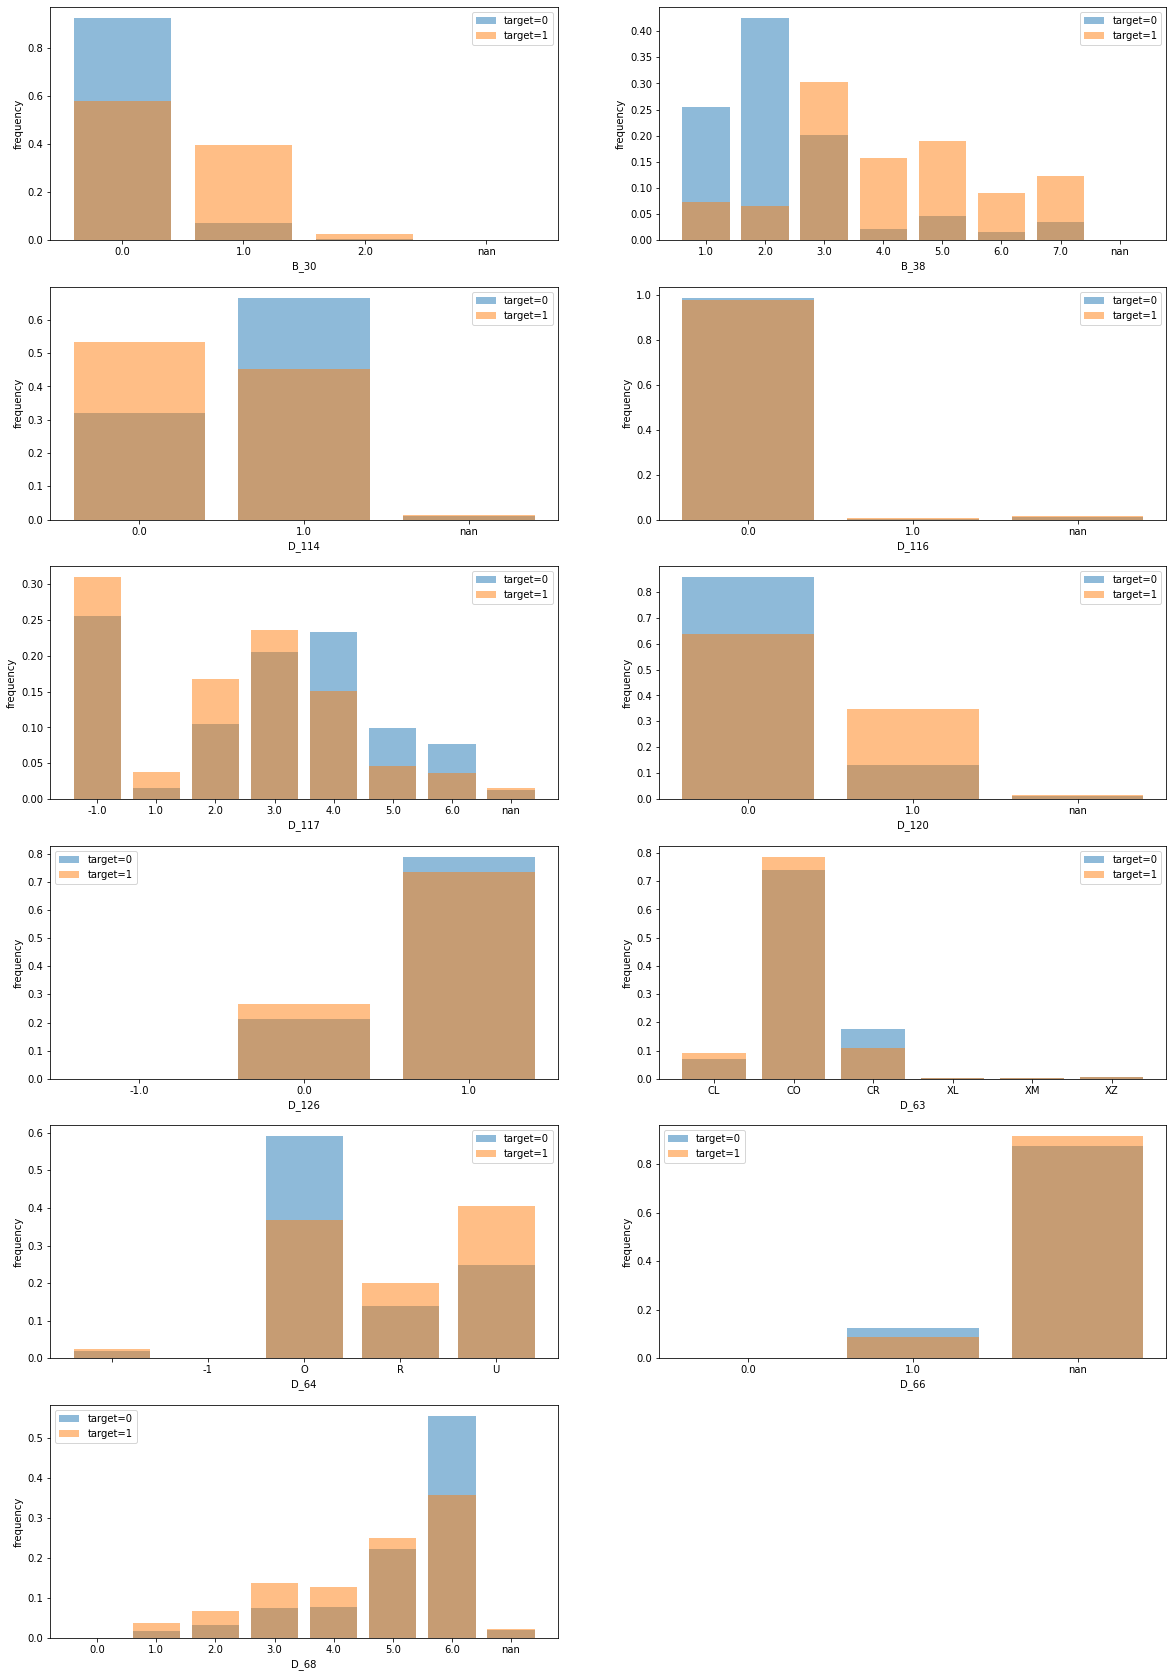

In [13]:
plt.figure(figsize=(20, 30))
for i, f in enumerate(categorical_cols):
    plt.subplot(6, 2, i+1)
    temp = pd.DataFrame(train_dataset[f][train_dataset.target == 0].value_counts(dropna=False, normalize=True).sort_index().rename('count'))
    temp.index.name = 'value'
    temp.reset_index(inplace=True)
    plt.bar(temp.index, temp['count'], alpha=0.5, label='target=0')
    temp = pd.DataFrame(train_dataset[f][train_dataset.target == 1].value_counts(dropna=False, normalize=True).sort_index().rename('count'))
    temp.index.name = 'value'
    temp.reset_index(inplace=True)
    plt.bar(temp.index, temp['count'], alpha=0.5, label='target=1')
    plt.xlabel(f)
    plt.ylabel('frequency')
    plt.legend()
    plt.xticks(temp.index, temp.value)
plt.show()

## Visualizing Numerical features

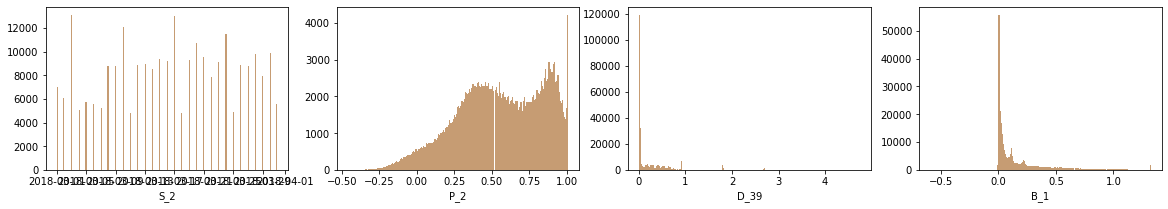

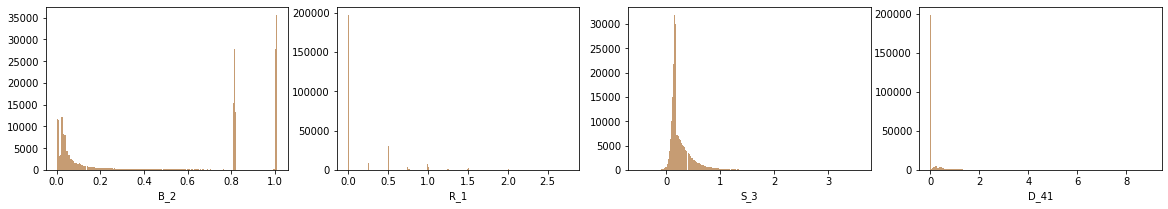

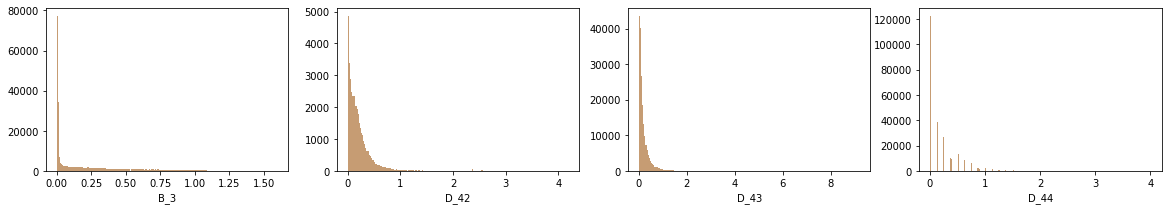

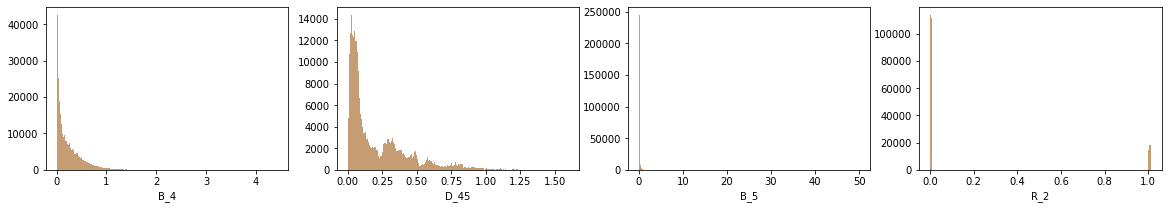

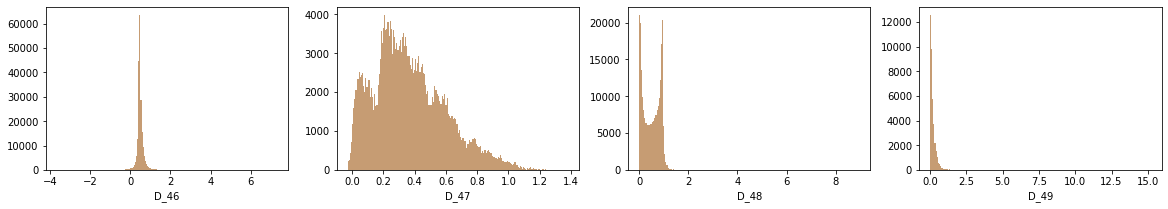

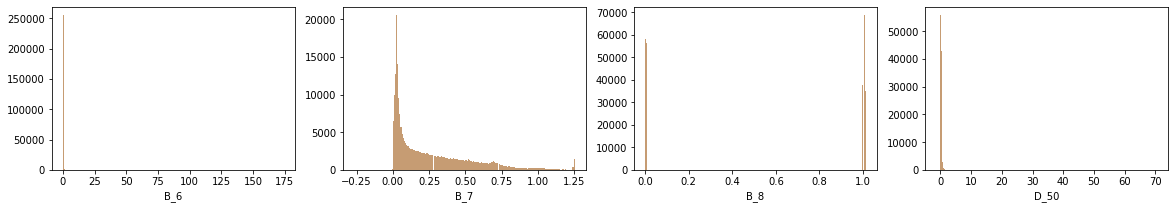

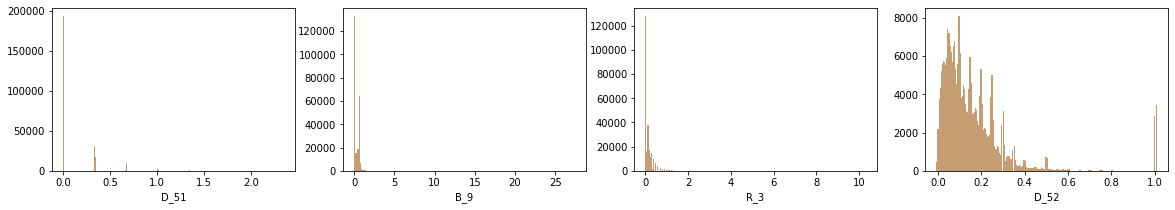

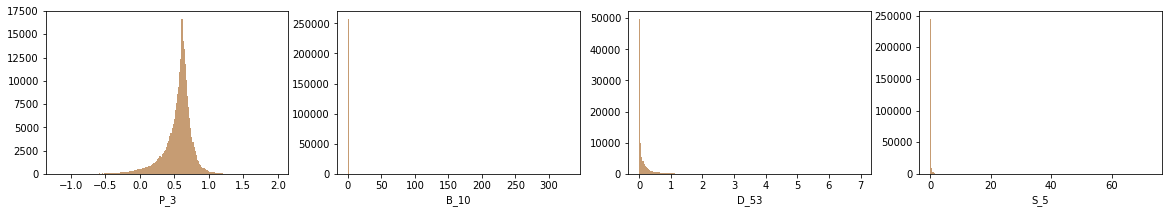

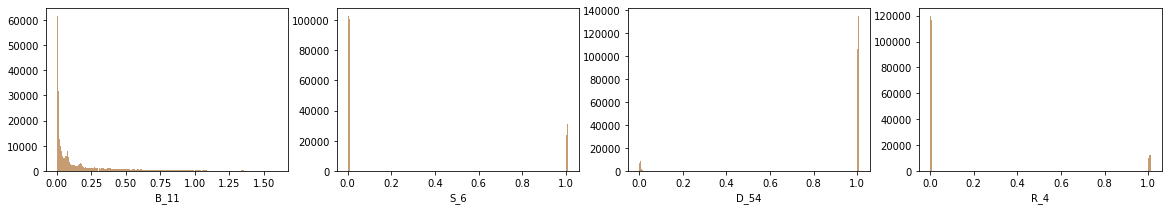

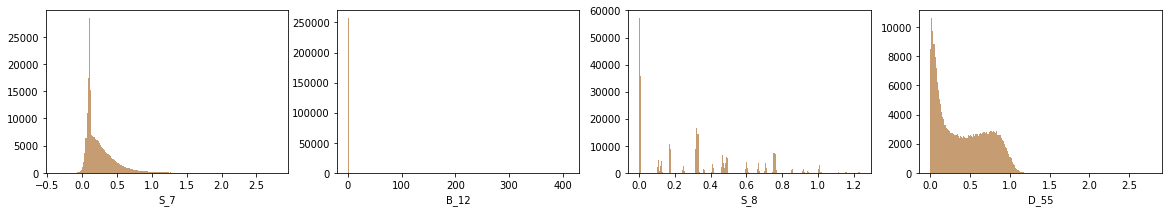

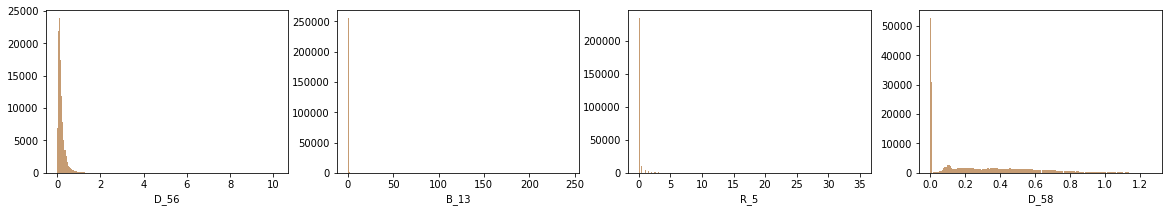

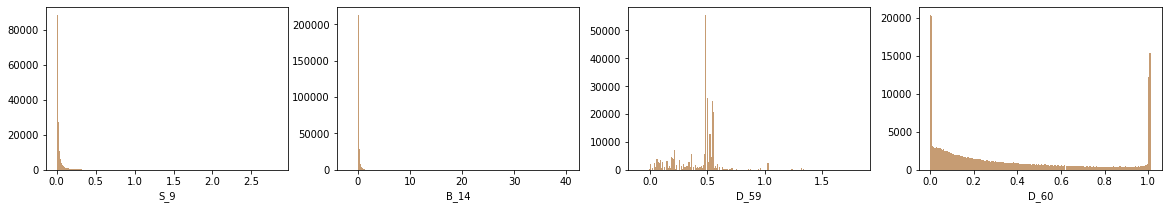

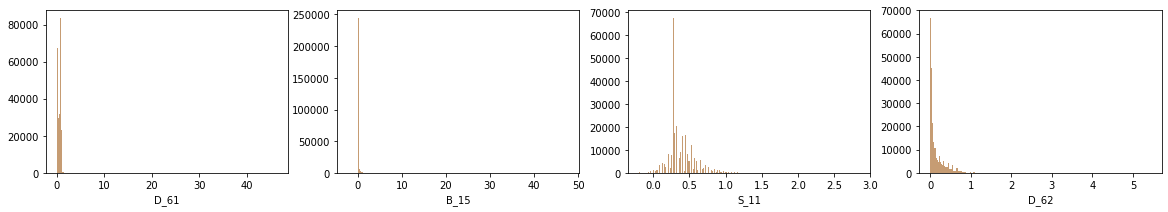

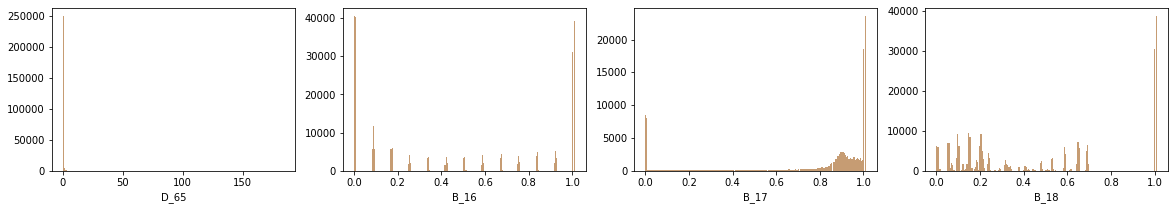

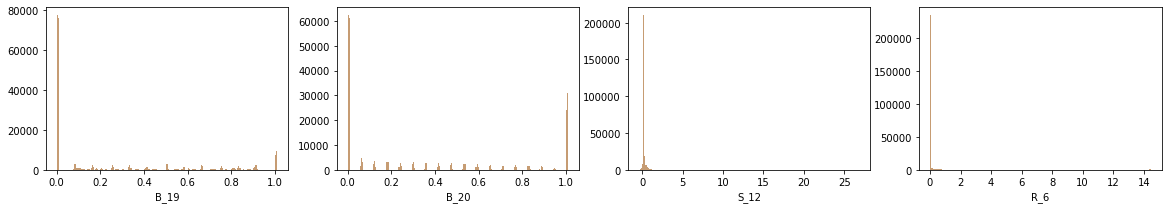

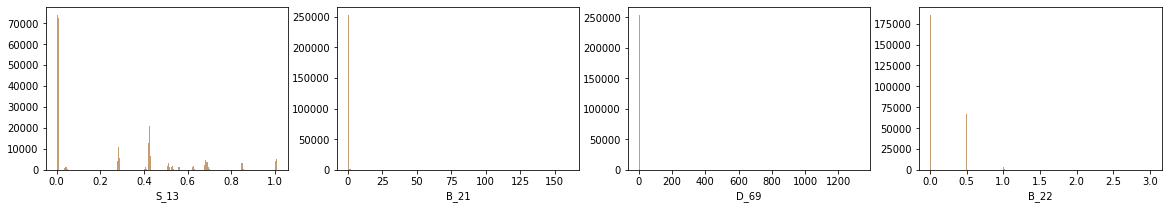

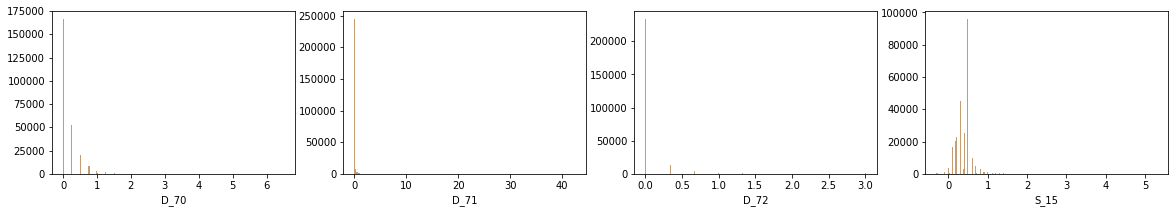

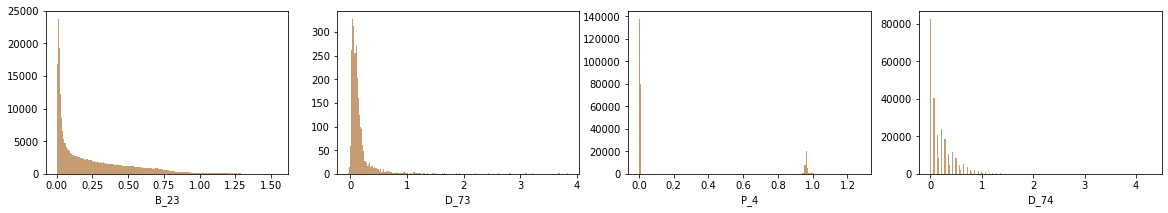

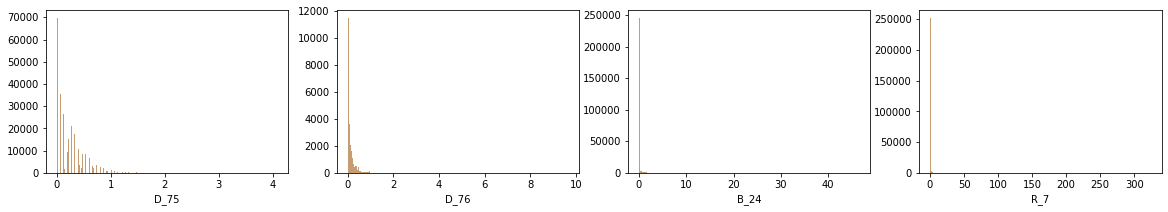

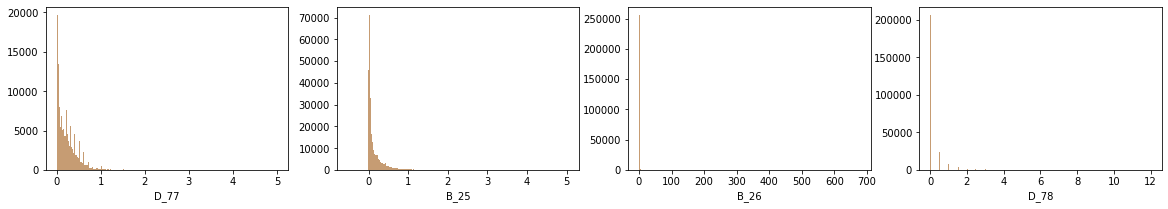

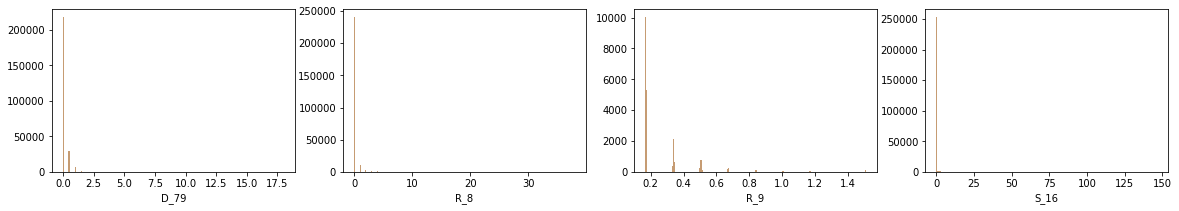

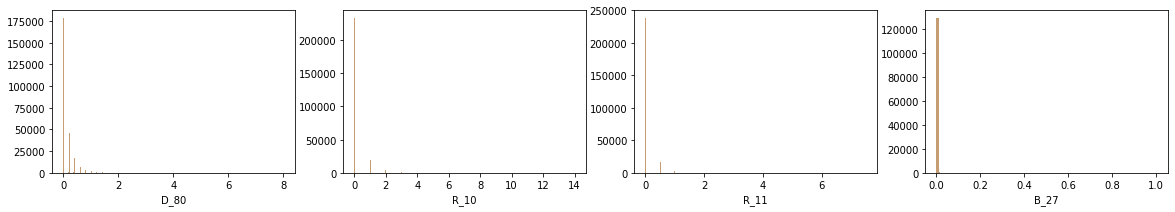

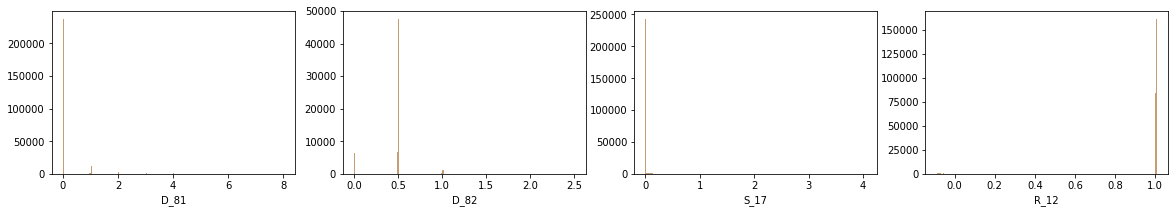

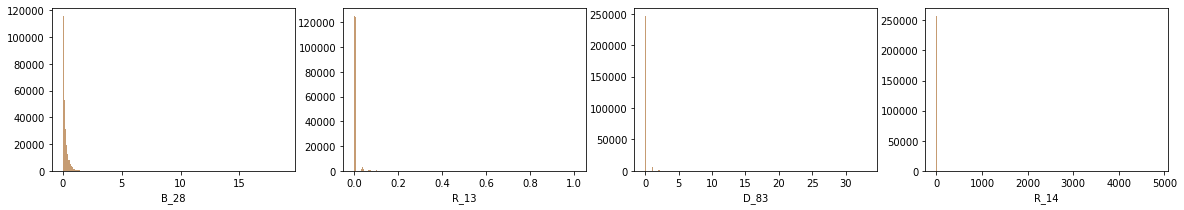

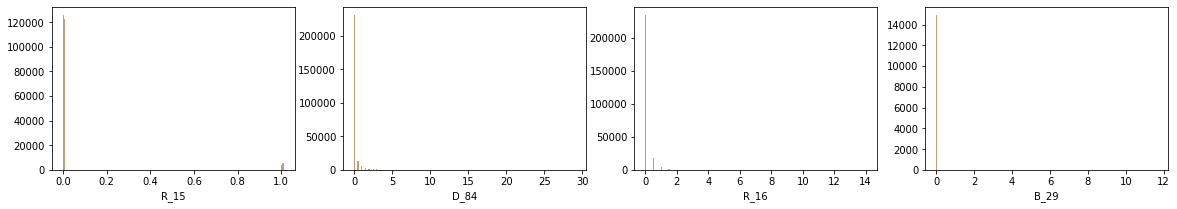

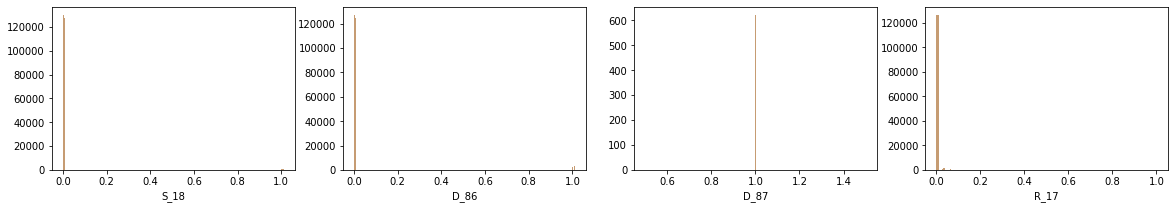

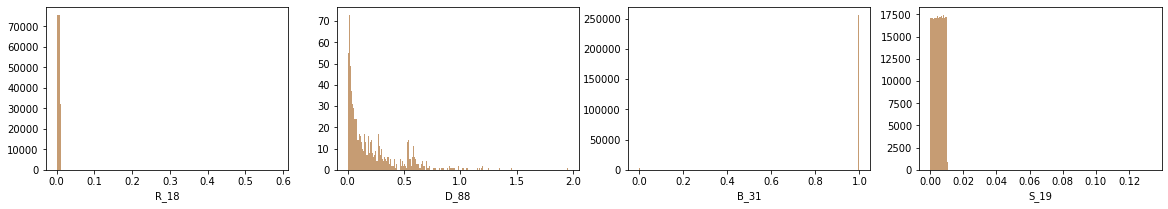

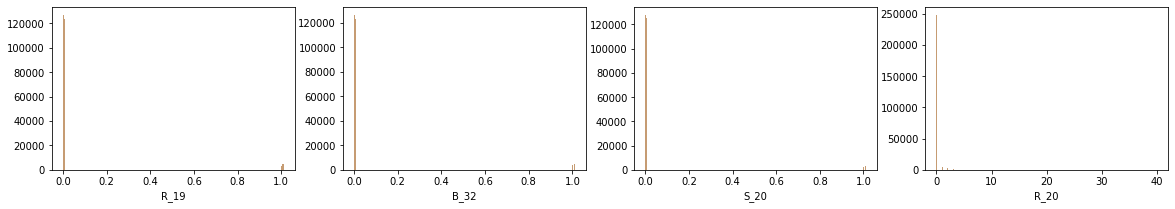

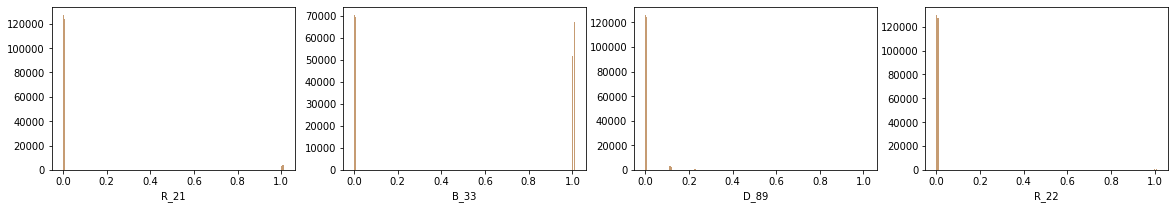

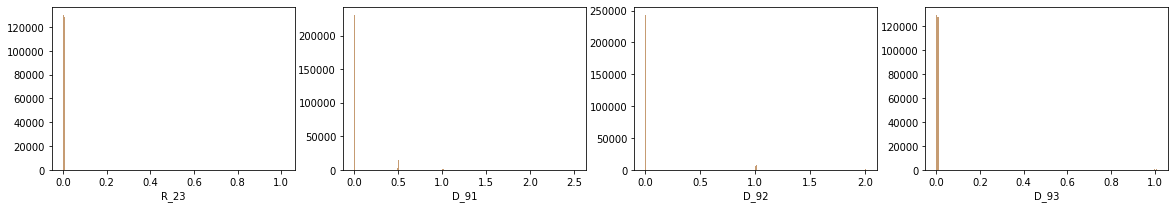

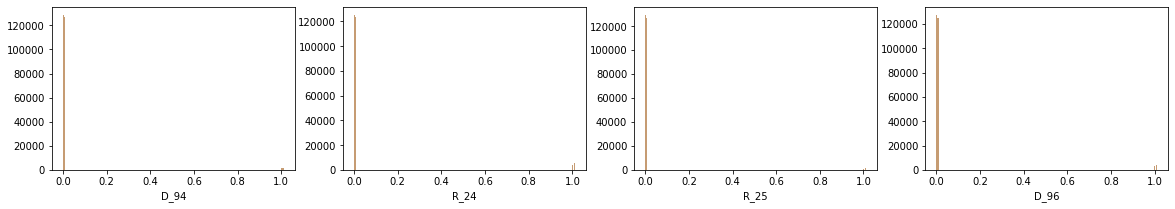

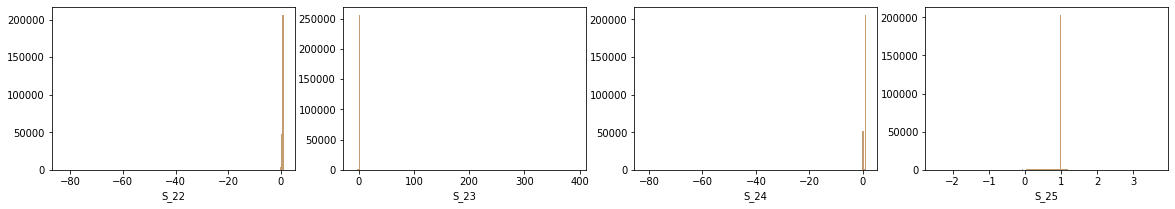

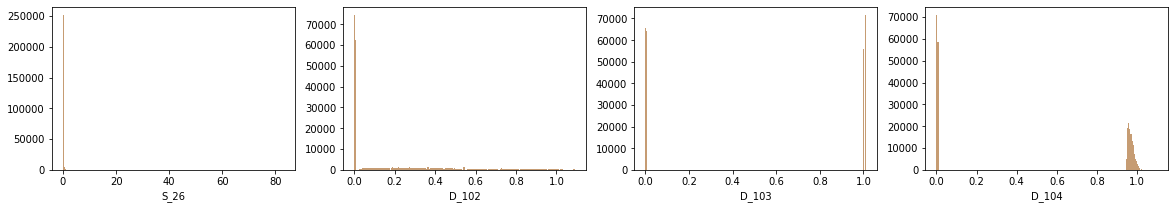

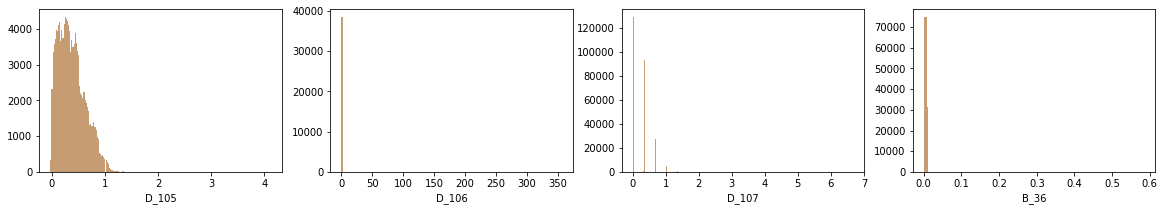

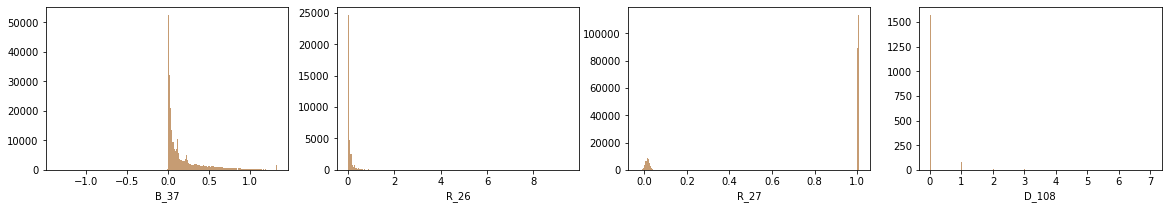

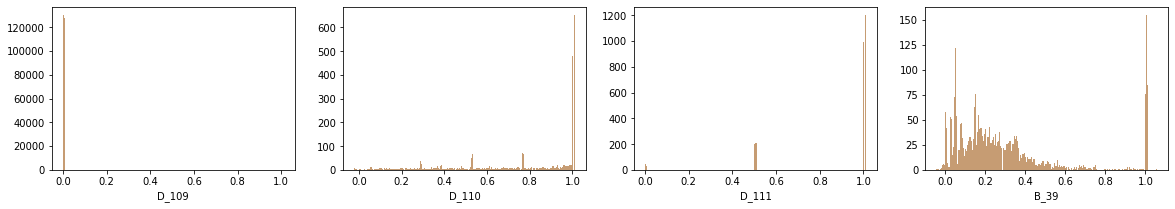

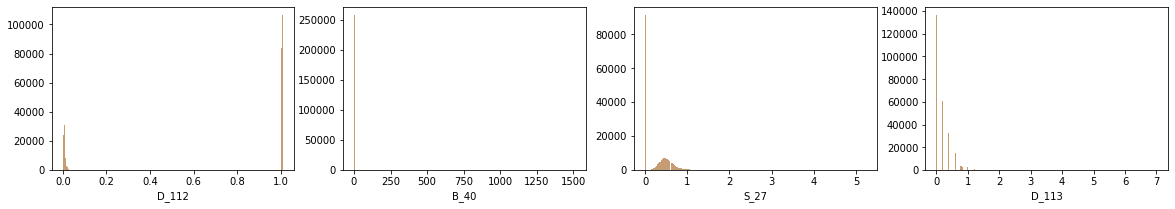

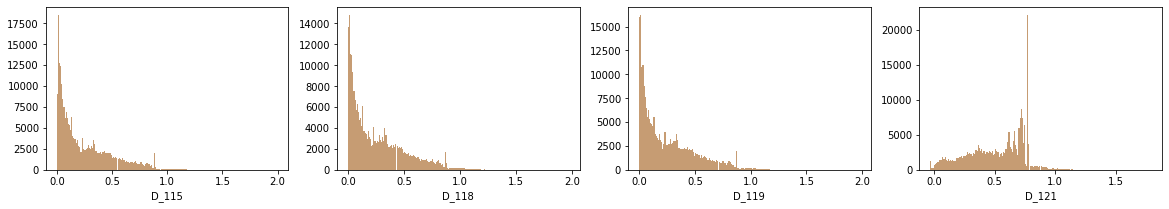

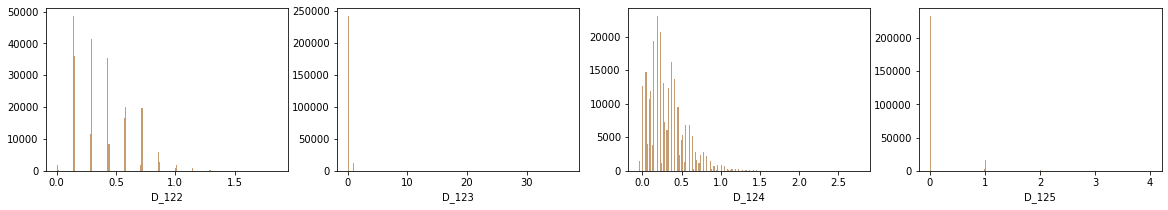

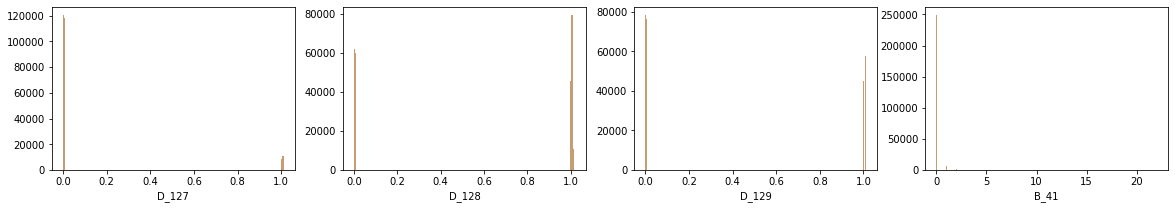

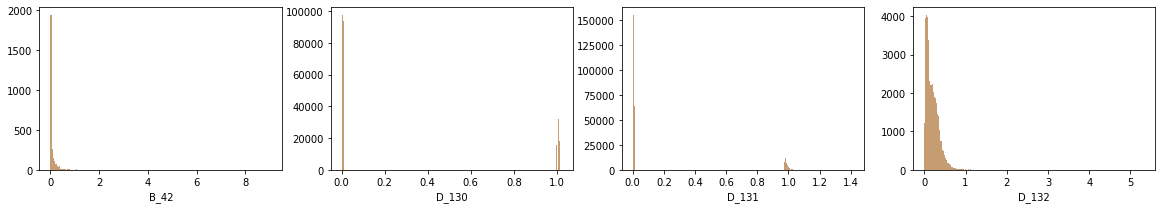

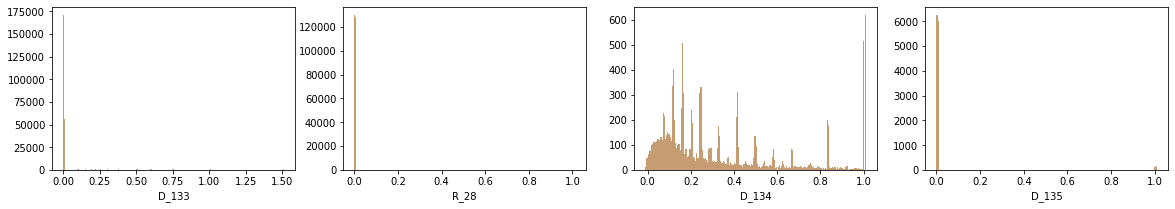

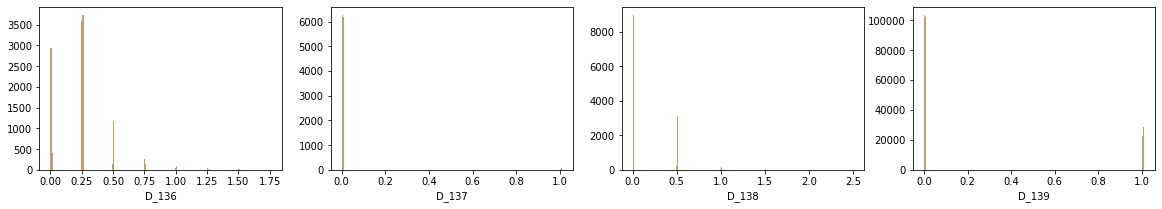

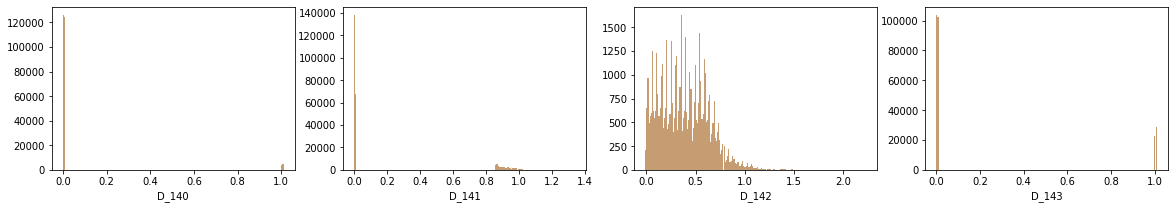

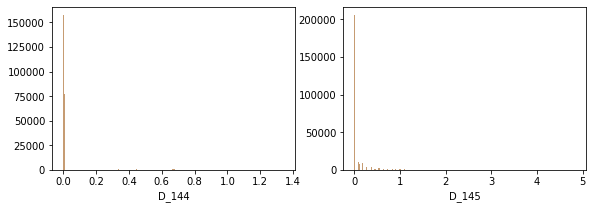

In [14]:
for i, l in enumerate(num_cols):
    if i % 4 == 0: 
        if i > 0: plt.show()
        plt.figure(figsize=(20, 3))
    plt.subplot(1, 4, i % 4 + 1)
    plt.hist(train_dataset[l], bins=200, color='#C69C73')
    plt.xlabel(l)
plt.show()

## Plot types of features

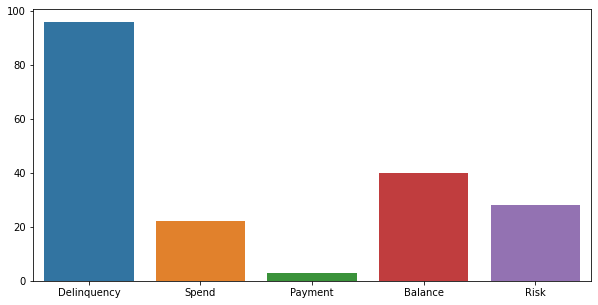

In [15]:
Delinquency = [d for d in train_dataset.columns if d.startswith('D_')]
Spend = [s for s in train_dataset.columns if s.startswith('S_')]
Payment = [p for p in train_dataset.columns if p.startswith('P_')]
Balance = [b for b in train_dataset.columns if b.startswith('B_')]
Risk = [r for r in train_dataset.columns if r.startswith('R_')]
Dict = {'Delinquency': len(Delinquency), 'Spend': len(Spend), 'Payment': len(Payment), 'Balance': len(Balance), 'Risk': len(Risk),}

plt.figure(figsize=(10,5))
sns.barplot(x=list(Dict.keys()), y=list(Dict.values()));

## Detect and remove outliers

In [ ]:
from scipy import stats
train_x5 = train_dataset.copy()
train_x5 = train_x5[(np.abs(stats.zscore(train_x5)) < 3).all(axis=1)]

In [ ]:
for i, l in enumerate(num_cols):
    if i % 4 == 0: 
        if i > 0: plt.show()
        plt.figure(figsize=(20, 3))
    plt.subplot(1, 4, i % 4 + 1)
    plt.hist(train_x5[l], bins=200, color='#C69C73')
    plt.xlabel(l)
plt.show()

## Handle null values

In [16]:
NaN_Val = np.array(train_dataset.isnull().sum())
NaN_prec = np.array((train_dataset.isnull().sum() * 100 / len(train_dataset)).round(2))
NaN_Col = pd.DataFrame([np.array(list(train_dataset.columns)).T,NaN_Val.T,NaN_prec.T,np.array(list(train_dataset.dtypes)).T], index=['Features','Num of Missing values','Percentage','DataType']
).transpose()
pd.set_option('display.max_rows', None)
NaN_Col

,Features,Num of Missing values,Percentage,DataType
0,S_2,0,0.0,datetime64[ns]
1,P_2,1480,0.57,float16
2,D_39,0,0.0,float16
3,B_1,0,0.0,float16
4,B_2,21,0.01,float16
5,R_1,0,0.0,float16
6,S_3,40265,15.55,float16
7,D_41,21,0.01,float16
8,B_3,21,0.01,float16
9,D_42,218205,84.28,float16


In [17]:
train_dataset = train_dataset.drop(['S_2','D_66','D_42','D_49','D_73','D_76','R_9','B_29','D_87','D_88','D_106','R_26','D_108','D_110','D_111','B_39','B_42','D_132','D_134','D_135','D_136','D_137','D_138','D_142'], axis=1)
categorical_cols.remove('D_66')

## Impute Using median

In [18]:
selected_col = np.array(['P_2','S_3','B_2','D_41','D_43','B_3','D_44','D_45','D_46','D_48','D_50','D_53','S_7','D_56','S_9','B_6','B_8','D_52','P_3','D_54','D_55','B_13','D_59','D_61','B_15','D_62','B_16','B_17','D_77','B_19','B_20','D_69','B_22','D_70','D_72','D_74','R_7','B_25','B_26','D_78','D_79','D_80','B_27','D_81','R_12','D_82','D_105','S_27','D_83','R_14','D_84','D_86','R_20','B_33','D_89','D_91','S_22','S_23','S_24','S_25','S_26','D_102','D_103','D_104','D_107','B_37','R_27','D_109','D_112','B_40','D_113','D_115','D_118','D_119','D_121','D_122','D_123','D_124','D_125','D_128','D_129','B_41','D_130','D_131','D_133','D_139','D_140','D_141','D_143','D_144','D_145'])

for col in selected_col:
    train_dataset[col] = train_dataset[col].fillna(train_dataset[col].median())

In [19]:
ff = ['S_2','D_66','D_42','D_49','D_73','D_76','R_9','B_29','D_87','D_88','D_106','R_26','D_108','D_110','D_111','B_39','B_42','D_132','D_134','D_135','D_136','D_137','D_138','D_142']
for i in categorical_cols:
    if(i in selected_col):
        print(i)

In [20]:
print(categorical_cols)

['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_68']


## Impute using mode

In [21]:
selcted_col2 = np.array(['D_68','B_30','B_38','D_64','D_114','D_116','D_117','D_120','D_126'])

for col2 in selcted_col2:
    train_dataset[col2] =  train_dataset[col2].fillna(train_dataset[col2].mode()[0])

## Loading test dataset - last record for each customer

In [22]:
test_dataset_ = pd.read_feather('../input/amexfeather/test_data.ftr')
test_dataset = test_dataset_.groupby('customer_ID').tail(1).set_index('customer_ID', drop=True).sort_index()

In [23]:
del test_dataset_
gc.collect()

23

In [24]:
train_dataset["D_68"].head()

customer_ID
00001b22f846c82c51f6e3958ccd81970162bae8b007e80662ef27519fcc18c1    6.0
00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8ad51ca8b8c4a24cefed    6.0
000084e5023181993c2e1b665ac88dbb1ce9ef621ec5370150fc2f8bdca6202c    6.0
0000f99513770170a1aba690daeeb8a96da4a39f11fc27da5c30a79db61c1e85    6.0
00013181a0c5fc8f1ea38cd2b90fe8ad2fa8cad9d9f13e4063bdf6b0f7d51eb6    5.0
Name: D_68, dtype: category
Categories (7, float64): [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0]

In [25]:
test_dataset.head()

,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_42,...,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
customer_ID,,,,,,,,,,,,,,,,,,,,,
00000469ba478561f23a92a868bd366de6f6527a684c9a2e78fb826dcac3b9b7,2019-10-12,0.568848,0.121399,0.010780,1.009766,0.006924,0.149414,0.000396,0.003576,0.10376,...,NaN,NaN,NaN,0.005913,0.001250,0.006542,NaN,0.009163,0.003691,0.003220
00001bf2e77ff879fab36aa4fac689b9ba411dae63ae397d4263dafa1daedef5,2019-04-15,0.841309,0.126465,0.016556,1.008789,0.009712,0.112183,0.006191,0.011383,NaN,...,NaN,NaN,NaN,0.004345,0.000866,0.009117,NaN,0.002197,0.000247,0.007778
0000210045da4f81e5f122c6bde5c2a617d03eef67f82c5e400fc98e7bd43ce8,2019-10-16,0.697754,0.002724,0.001485,0.810059,0.002621,0.166138,0.004887,0.015945,NaN,...,NaN,NaN,NaN,1.000977,0.008896,0.895996,0.150146,1.009766,0.457764,0.092041
00003b41e58ede33b8daf61ab56d9952f17c9ad1c3976cf6e56734528702d694,2019-04-22,0.513184,0.324707,0.149536,0.205688,0.002277,0.181152,0.005814,0.498535,NaN,...,NaN,NaN,NaN,1.007812,0.003754,0.919922,0.255371,1.007812,0.500977,0.182983
00004b22eaeeeb0ec976890c1d9bfc14fd9427e98c4ee9a4693dd914fca22557,2019-10-22,0.254395,0.768066,0.563477,0.038025,0.502930,0.168335,0.009483,0.831055,NaN,...,NaN,NaN,NaN,0.006622,0.001140,0.009529,NaN,0.009407,0.001557,0.000525


In [26]:
test_dataset.shape

(924621, 189)

## Check nulls in the test dataset

In [27]:
NaN_Val2 = np.array(test_dataset.isnull().sum())
NaN_prec2 = np.array((test_dataset.isnull().sum() * 100 / len(test_dataset)).round(2))
NaN_Col2 = pd.DataFrame([np.array(list(test_dataset.columns)).T,NaN_Val2.T,NaN_prec2.T,np.array(list(test_dataset.dtypes)).T], index=['Features','Num of Missing values','Percentage','DataType']
).transpose()
pd.set_option('display.max_rows', None)

NaN_Col2

,Features,Num of Missing values,Percentage,DataType
0,S_2,0,0.0,datetime64[ns]
1,P_2,4784,0.52,float16
2,D_39,0,0.0,float16
3,B_1,0,0.0,float16
4,B_2,43,0.0,float16
5,R_1,0,0.0,float16
6,S_3,144280,15.6,float16
7,D_41,43,0.0,float16
8,B_3,43,0.0,float16
9,D_42,827578,89.5,float16


In [28]:
test_dataset = test_dataset.drop(['S_2','D_42','D_49','D_66','D_73','D_76','R_9','B_29','D_87','D_88','D_106','R_26','D_108','D_110','D_111','B_39','B_42','D_132','D_134','D_135','D_136','D_137','D_138','D_142'], axis=1)

## Impute using median

In [29]:
selected_column = np.array(['P_2','S_3','B_2','D_41','D_43','B_3','D_44','D_45','D_46','D_48','D_50','D_53','S_7','D_56','S_9','S_12','S_17','B_6','B_8','D_52','P_3','D_54','D_55','B_13','D_59','D_61','B_15','D_62','B_16','B_17','D_77','B_19','B_20','D_69','B_22','D_70','D_72','D_74','R_7','B_25','B_26','D_78','D_79','D_80','B_27','D_81','R_12','D_82','D_105','S_27','D_83','R_14','D_84','D_86','R_20','B_33','D_89','D_91','S_22','S_23','S_24','S_25','S_26','D_102','D_103','D_104','D_107','B_37','R_27','D_109','D_112','B_40','D_113','D_115','D_118','D_119','D_121','D_122','D_123','D_124','D_125','D_128','D_129','B_41','D_130','D_131','D_133','D_139','D_140','D_141','D_143','D_144','D_145'])

for column in selected_column:
    test_dataset[column] = test_dataset[column].fillna(test_dataset[column].median())

## Impute using mode

In [30]:
selected_column2 = np.array(['D_68','B_30','B_38','D_114','D_116','D_117','D_120','D_126'])

for column2 in selected_column2:
    test_dataset[column2] =  test_dataset[column2].fillna(test_dataset[column2].mode()[0])

In [31]:
test_dataset.shape

(924621, 165)

In [32]:
test_dataset.head()

,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_43,D_44,...,D_130,D_131,D_133,R_28,D_139,D_140,D_141,D_143,D_144,D_145
customer_ID,,,,,,,,,,,,,,,,,,,,,
00000469ba478561f23a92a868bd366de6f6527a684c9a2e78fb826dcac3b9b7,0.568848,0.121399,0.010780,1.009766,0.006924,0.149414,0.000396,0.003576,0.007397,0.006786,...,0.004902,0.000975,0.006271,0.008820,0.005913,0.001250,0.006542,0.009163,0.003691,0.003220
00001bf2e77ff879fab36aa4fac689b9ba411dae63ae397d4263dafa1daedef5,0.841309,0.126465,0.016556,1.008789,0.009712,0.112183,0.006191,0.011383,0.096863,0.004234,...,0.001252,0.007633,0.002768,0.008789,0.004345,0.000866,0.009117,0.002197,0.000247,0.007778
0000210045da4f81e5f122c6bde5c2a617d03eef67f82c5e400fc98e7bd43ce8,0.697754,0.002724,0.001485,0.810059,0.002621,0.166138,0.004887,0.015945,0.105286,0.003382,...,1.003906,0.001152,0.002045,0.001852,1.000977,0.008896,0.895996,1.009766,0.457764,0.092041
00003b41e58ede33b8daf61ab56d9952f17c9ad1c3976cf6e56734528702d694,0.513184,0.324707,0.149536,0.205688,0.002277,0.181152,0.005814,0.498535,0.211670,0.258545,...,0.009438,0.002775,0.009377,0.003622,1.007812,0.003754,0.919922,1.007812,0.500977,0.182983
00004b22eaeeeb0ec976890c1d9bfc14fd9427e98c4ee9a4693dd914fca22557,0.254395,0.768066,0.563477,0.038025,0.502930,0.168335,0.009483,0.831055,0.071899,0.375732,...,0.003340,0.001000,0.007942,0.009232,0.006622,0.001140,0.009529,0.009407,0.001557,0.000525


## Encode categorical features

In [33]:
# Convert categorical variable to numericals
from sklearn.preprocessing import OrdinalEncoder

enc = OrdinalEncoder()


train_dataset[categorical_cols] = enc.fit_transform(train_dataset[categorical_cols])
test_dataset[categorical_cols] = enc.transform(test_dataset[categorical_cols])

In [34]:
categorical_cols

['B_30',
 'B_38',
 'D_114',
 'D_116',
 'D_117',
 'D_120',
 'D_126',
 'D_63',
 'D_64',
 'D_68']

In [35]:
train_dataset["D_63"].head()

customer_ID
00001b22f846c82c51f6e3958ccd81970162bae8b007e80662ef27519fcc18c1    1.0
00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8ad51ca8b8c4a24cefed    1.0
000084e5023181993c2e1b665ac88dbb1ce9ef621ec5370150fc2f8bdca6202c    1.0
0000f99513770170a1aba690daeeb8a96da4a39f11fc27da5c30a79db61c1e85    1.0
00013181a0c5fc8f1ea38cd2b90fe8ad2fa8cad9d9f13e4063bdf6b0f7d51eb6    1.0
Name: D_63, dtype: float64

## Remove highly corelated features

In [36]:
train_dataset_without_target = train_dataset.drop(["target"],axis=1)

cor_matrix = train_dataset_without_target.corr()
col_core = set()

for i in range(len(cor_matrix.columns)):
    for j in range(i):
        if(cor_matrix.iloc[i, j] > 0.9):
            col_name = cor_matrix.columns[i]
            col_core.add(col_name)
col_core

{'B_11',
 'B_13',
 'B_20',
 'B_23',
 'B_33',
 'B_37',
 'D_104',
 'D_119',
 'D_141',
 'D_143',
 'D_74',
 'D_75',
 'D_77',
 'S_24',
 'S_7'}

In [37]:
train_dataset = train_dataset.drop(col_core, axis=1)
test_dataset = test_dataset.drop(col_core, axis=1)

In [38]:
train_dataset.shape

(258913, 151)

In [39]:
num_columns = [col for col in train_dataset.columns if col not in ["target"]]

X = train_dataset[num_columns]
y = train_dataset['target']

print(f"X shape is = {X.shape}" )
print(f"Y shape is = {y.shape}" )

X shape is = (258913, 150)
Y shape is = (258913,)


## Split dataset into train and test

In [40]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

x_train,x_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"X_train shape is = {x_train.shape}" )
print(f"Y_train shape is = {y_train.shape}" )
print(f"X_test shape is = {x_test.shape}" )
print(f"Y_test shape is = {y_test.shape}" )

X_train shape is = (207130, 150)
Y_train shape is = (207130,)
X_test shape is = (51783, 150)
Y_test shape is = (51783,)


In [41]:
from sklearn.metrics import roc_auc_score

# Model building

# LightGBM

In [42]:
import lightgbm as lgb

d_train = lgb.Dataset(x_train, label=y_train, categorical_feature = categorical_cols)

params = {'objective': 'binary','n_estimators': 1200,'metric': 'binary_logloss','boosting': 'gbdt','num_leaves': 90,'reg_lambda' : 50,'colsample_bytree': 0.19,'learning_rate': 0.03,'min_child_samples': 2400,'max_bins': 511,'seed': 42,'verbose': -1}

model = lgb.train(params, d_train, 100)

In [43]:
predictions = model.predict(test_dataset[num_columns])
predictions

array([0.05448141, 0.00553044, 0.07610592, ..., 0.69545096, 0.3839248 ,
       0.07296717])

In [44]:
sample_dataset = pd.read_csv('/kaggle/input/amex-default-prediction/sample_submission.csv')
output = pd.DataFrame({'customer_ID': sample_dataset.customer_ID, 'prediction': predictions})
output.to_csv('submission_LGB.csv', index=False)

# Catboost Classifier

In [45]:
from catboost import CatBoostClassifier

model = CatBoostClassifier(iterations=100, learning_rate=0.1, depth=10, verbose=False)

model.fit(x_train, y_train)

predictions = model.predict(x_test)

In [46]:
roc_auc_score(y_test,predictions,average='macro')

0.8914201675278535

In [47]:
predictions_test = model.predict(test_dataset)

In [48]:
predictions_test.shape

(924621,)

In [49]:
sample_dataset = pd.read_csv('/kaggle/input/amex-default-prediction/sample_submission.csv')
output = pd.DataFrame({'customer_ID': sample_dataset.customer_ID, 'prediction': predictions_test})
output.to_csv('submission_v1.csv', index=False)

## XGBoost Classifier

In [50]:
model_parameters = {
            'n_estimators': 100,
            'max_features': 0.33,
            'max_depth': 6
        }

In [51]:
from xgboost.sklearn import XGBClassifier

model = XGBClassifier(**model_parameters)
model.fit(x_train, y_train)

[13:44:32] WARNING: ../src/learner.cc:627: 
Parameters: { "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_features=0.33, max_leaves=0,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, ...)

In [52]:
predictions = model.predict(x_test)
roc_auc_score(y_test,predictions,average='macro')

0.8902009461796003

In [53]:
predictions_test = model.predict(test_dataset)

In [54]:
predictions_test.shape

(924621,)

In [55]:
sample_dataset = pd.read_csv('/kaggle/input/amex-default-prediction/sample_submission.csv')
output = pd.DataFrame({'customer_ID': sample_dataset.customer_ID, 'prediction': predictions_test})
output.to_csv('submission_XGB_v1.csv', index=False)

# KNN Classifier

In [60]:
from sklearn.neighbors import KNeighborsClassifier
  
model = KNeighborsClassifier(n_neighbors=5)
  
model.fit(x_train, y_train)

# Make predictions on the test data
predictions = model.predict(x_test)
roc_auc_score(y_test,predictions,average='macro')

0.70888041213


In [61]:
predictions_test = model.predict(test_dataset)

In [62]:
predictions_test.shape

(924621,)


In [63]:
sample_dataset = pd.read_csv('/kaggle/input/amex-default-prediction/sample_submission.csv')
output = pd.DataFrame({'customer_ID': sample_dataset.customer_ID, 'prediction': predictions_test})
output.to_csv('submission_knn.csv', index=False)

## SVM 

In [64]:
from sklearn import svm

model = svm.SVC(kernel='linear') # Linear Kernel

model.fit(x_train ,y_train)

In [68]:
predictions = model.predict(x_test)
roc_auc_score(y_test,predictions,average='macro')

0.524531562


In [69]:
predictions_test = model.predict(test_dataset)

In [70]:
sample_dataset = pd.read_csv('/kaggle/input/amex-default-prediction/sample_submission.csv')
output = pd.DataFrame({'customer_ID': sample_dataset.customer_ID, 'prediction': predictions_test})
output.to_csv('submission_knn.csv', index=False)

## Evaluate Model Performance

In [56]:
def amex_metric_mod(y_true, y_pred):

    labels     = np.transpose(np.array([y_true, y_pred]))
    labels     = labels[labels[:, 1].argsort()[::-1]]
    weights    = np.where(labels[:,0]==0, 20, 1)
    cut_vals   = labels[np.cumsum(weights) <= int(0.04 * np.sum(weights))]
    top_four   = np.sum(cut_vals[:,0]) / np.sum(labels[:,0])

    gini = [0,0]
    for i in [1,0]:
        labels         = np.transpose(np.array([y_true, y_pred]))
        labels         = labels[labels[:, i].argsort()[::-1]]
        weight         = np.where(labels[:,0]==0, 20, 1)
        weight_random  = np.cumsum(weight / np.sum(weight))
        total_pos      = np.sum(labels[:, 0] *  weight)
        cum_pos_found  = np.cumsum(labels[:, 0] * weight)
        lorentz        = cum_pos_found / total_pos
        gini[i]        = np.sum((lorentz - weight_random) * weight)

    return 0.5 * (gini[1]/gini[0] + top_four)

In [57]:
amex_metric_mod(y_test,predictions)

0.5101283087490031

In [58]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

def eval_model(y_pred, y_test):
    print("MAE", mean_absolute_error(y_test, y_pred))
    print("MSE",mean_squared_error(y_test,y_pred))
    print("RMSE",np.sqrt(mean_squared_error(y_test,y_pred)))
    print("RMSLE",np.log(np.sqrt(mean_squared_error(y_test,y_pred))))
    r2 = r2_score(y_test,y_pred)
    print('R Squared', r2)
    n=40
    k=2
    adj_r2_score = 1 - ((1-r2)*(n-1)/(n-k-1))
    print('Adj R Squared',adj_r2_score)

In [59]:
eval_model(predictions, y_test)

MAE 0.11075063244694204
MSE 0.11075063244694204
RMSE 0.3327921760602885
RMSLE -1.100237079745664
R Squared 0.5539917351185878
Adj R Squared 0.5298831802601331
